In [ ]:
%cd /src/HAI_Flask

In [2]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # will suppress all warnings
import neuralgym as ng

from engine.deepfillv1.inpaint_model import InpaintCAModel
from engine.deepfillv1.inpaint_ops import flow_to_image_tf

from engine.utils import Namespace
from engine.utils import get_colormap_image

In [3]:
prefix = 'engine/testfiles'
args = Namespace(image = 'engine/input_image.png',
                 mask = 'engine/input_mask.png',
                 flow =  prefix + '/output_flow.png',
                 output =  prefix + '/output.png',
                 output_modulated =  prefix + '/output_modulated.png',
                 output_flow_modulated =  prefix + '/output_flow_modulated.png',
                 checkpoint_dir = 'engine/deepfillv1/model_logs')
#ng.get_gpus(1)

Shape of image: (296, 560, 3)
Shape of mask: (296, 560, 3)
Shape of downsampled mask: (37, 70, 3)
Shape of restored mask: (296, 560, 3)
Shape of model input: (1, 296, 1120, 3)
Shape of input flow: (1, 296, 560, 3)


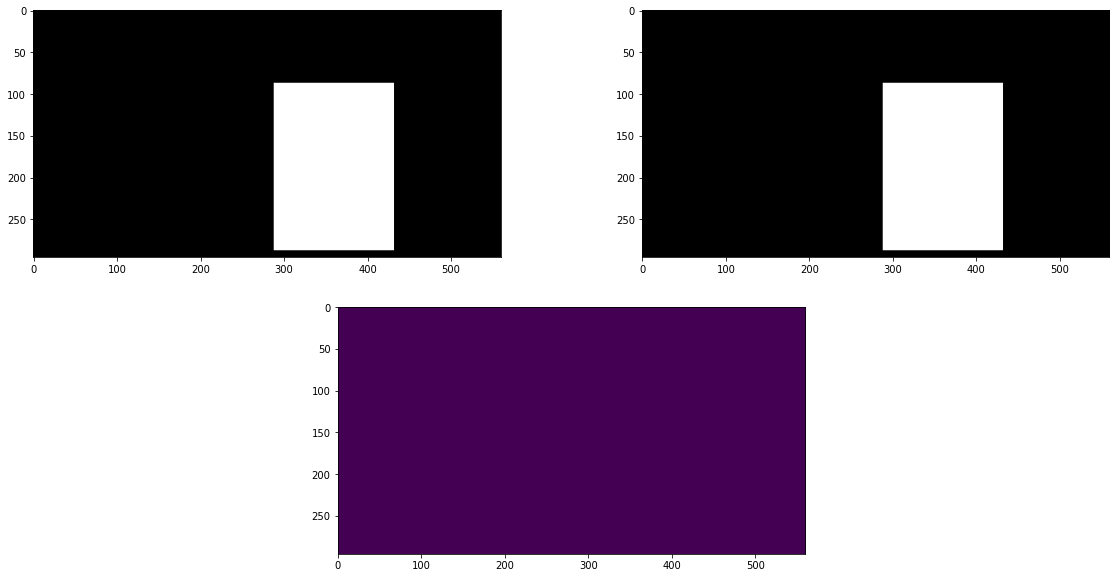

In [4]:
tf.reset_default_graph()
model = InpaintCAModel()
image = cv2.imread(args.image)
mask0 = cv2.imread(args.mask)

h0, w0, _ = image.shape
grid = 8
image = image[:h0//grid*grid, :w0//grid*grid, :]
mask0 = mask0[:h0//grid*grid, :w0//grid*grid, :]
h, w, _ = image.shape
print('Shape of image: {}'.format(image.shape))
print('Shape of mask: {}'.format(mask0.shape))

assert image.shape == mask0.shape

# quantize mask
dratio = 8
dw, dh = w // dratio, h // dratio
mask_downsampled = cv2.resize(mask0, dsize=(dw, dh), interpolation=cv2.INTER_NEAREST)
mask = cv2.resize(mask_downsampled, dsize=(w, h), interpolation=cv2.INTER_NEAREST)
print('Shape of downsampled mask: {}'.format(mask_downsampled.shape))
print('Shape of restored mask: {}'.format(mask.shape))

image = np.expand_dims(image, 0)
mask = np.expand_dims(mask, 0)
input_image = np.concatenate([image, mask], axis=2)
print('Shape of model input: {}'.format(input_image.shape))

flow = cv2.imread(args.flow)
flow = flow[:h//grid*grid, :w//grid*grid, :]
input_flow = np.expand_dims(flow, 0)
print('Shape of input flow: {}'.format(input_flow.shape))
assert image.shape == input_flow.shape

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(221)
plt.imshow(mask0.astype(np.float) / 255)
ax.set_aspect('equal')
ax = fig.add_subplot(222)
plt.imshow(mask[0].astype(np.float) / 255)
ax.set_aspect('equal')
ax = fig.add_subplot(212)
err = (mask0 - mask[0]).astype(np.float) / 255
err = (err ** 2).sum(-1) ** 0.5
plt.imshow(err)
ax.set_aspect('equal')

296 560 37 70


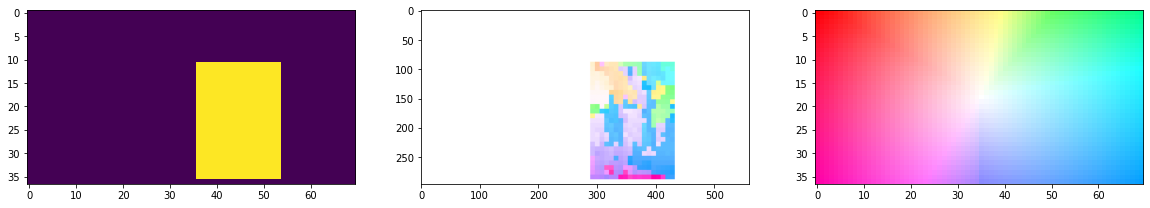

In [5]:
dratio = 8
dw, dh = w//dratio, h//dratio
print(h, w, dh, dw)
mask_downsampled = cv2.resize(mask[0][..., -1], dsize=(dw, dh), interpolation=cv2.INTER_NEAREST)
input_flow_downsampled = cv2.resize(input_flow[0], dsize=(dw, dh), interpolation=cv2.INTER_NEAREST)

sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True
with tf.Session(config=sess_config) as sess:
    colormap = get_colormap_image(dw, dh, dw, dh)
    colormap = (colormap + 1.) * 127.5
    colormap = tf.reverse(colormap, [-1])
    colormap = tf.saturate_cast(colormap, tf.uint8)
    colormap = sess.run(colormap)
    colormap = np.array(colormap)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(131)
plt.imshow(mask_downsampled.astype(np.float) / 255)
ax.set_aspect('equal')
ax = fig.add_subplot(132)
plt.imshow(input_flow[0][:, :, ::-1].astype(np.float) / 255)
ax.set_aspect('equal')
ax = fig.add_subplot(133)
plt.imshow(colormap[0].astype(np.float) / 255)
ax.set_aspect('equal')

In [6]:
# convert colormap to attention coefficients
def reverse_map(flow, cmap):
    assert flow.shape == cmap.shape
    h, w, _ = flow.shape
    # for each flow pixel, find nearest neighbor position in cmap
    flow_tiled = np.tile(np.reshape(flow, [h, w, 1, 1, 3]), [1, 1, h, w, 1]) / 255
    cmap_tiled = np.tile(np.reshape(cmap, [1, 1, h, w, 3]), [h, w, 1, 1, 1]) / 255
    dist = ((cmap_tiled - flow_tiled) ** 2).sum(-1)
    dist = np.reshape(dist, [h * w, h * w])
    idx = np.argmax(-dist, axis=-1)
    
    print(idx)
    
    # convert to one-hot attention
    att_values = np.zeros((h * w, h * w)).astype(np.float32)
    att_values[np.arange(h * w), idx] = 1.
    att_values = np.reshape(att_values, [h, w, h * w])

    return att_values

input_att = np.expand_dims(reverse_map(input_flow_downsampled[:, :, ::-1], colormap[0]), 0)
print(f'Shape of attention input: {input_att.shape}')

[1295 1295 1295 ... 1295 1295 1295]
Shape of attention input: (1, 37, 70, 2590)


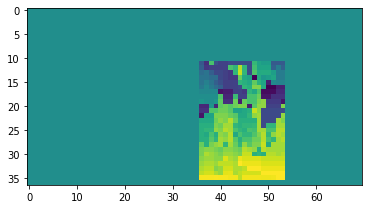

In [7]:
# artificial attention
noise_ratio = 0

sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True
with tf.Session(config=sess_config) as sess:
    mm = tf.reshape(tf.cast(mask_downsampled, tf.float32), [1, dh, dw, 1])
    
    artificial_att = tf.random.normal((1, dh, dw, input_att.shape[-1])) ** 2
    artificial_att /= tf.reduce_sum(artificial_att, -1, keepdims=True)
    
    masked_noise = mm * artificial_att
    masked_input = mm * tf.constant(input_att, tf.float32)
    masked = masked_noise * noise_ratio + masked_input * (1 - noise_ratio)
    intact = tf.constant(input_att, tf.float32) * (1 - mm)
    
    artificial_att = masked + intact
    artificial_att = sess.run(artificial_att)
    artificial_att = np.array(artificial_att)

fig = plt.figure()
ax = fig.add_subplot(111)
idximg = np.argmax(artificial_att, axis=-1)
plt.imshow(idximg[0] / idximg.max())
ax.set_aspect('equal')

In [8]:
input_att = artificial_att

In [9]:
offset = np.argmax(input_att[0], axis=-1).astype(np.int32)
print(offset)
tmp_h, tmp_w = input_att.shape[1], input_att.shape[2]
offset = np.stack([offset // tmp_w, offset % tmp_w], axis=-1)
offset = np.expand_dims(offset, 0)
h_add = np.tile(np.reshape(np.arange(tmp_h), [1, tmp_h, 1, 1]), [1, 1, tmp_w, 1])
w_add = np.tile(np.reshape(np.arange(tmp_w), [1, 1, tmp_w, 1]), [1, tmp_h, 1, 1])
h_ctr = np.ones((1, tmp_h, tmp_w, 1)).astype(np.int32) * tmp_h // 2
w_ctr = np.ones((1, tmp_h, tmp_w, 1)).astype(np.int32) * tmp_w // 2
offset = offset - np.concatenate([h_ctr, w_ctr], axis=3)
offset = offset * np.expand_dims(mask_downsampled, (0, -1)).astype(np.int32)
# to flow image
sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True
with tf.Session(config=sess_config) as sess:
    offset = tf.constant(offset, dtype=tf.float32)
    flow = flow_to_image_tf(offset)
    flow = (flow + 1.) * 127.5
    flow = tf.reverse(flow, [-1])
    flow = tf.saturate_cast(flow, tf.uint8)
    flow = sess.run(flow)
    flow = np.array(flow)
print(flow.shape)

[[1295 1295 1295 ... 1295 1295 1295]
 [1295 1295 1295 ... 1295 1295 1295]
 [1295 1295 1295 ... 1295 1295 1295]
 ...
 [1295 1295 1295 ... 1295 1295 1295]
 [1295 1295 1295 ... 1295 1295 1295]
 [1295 1295 1295 ... 1295 1295 1295]]
(1, 37, 70, 3)


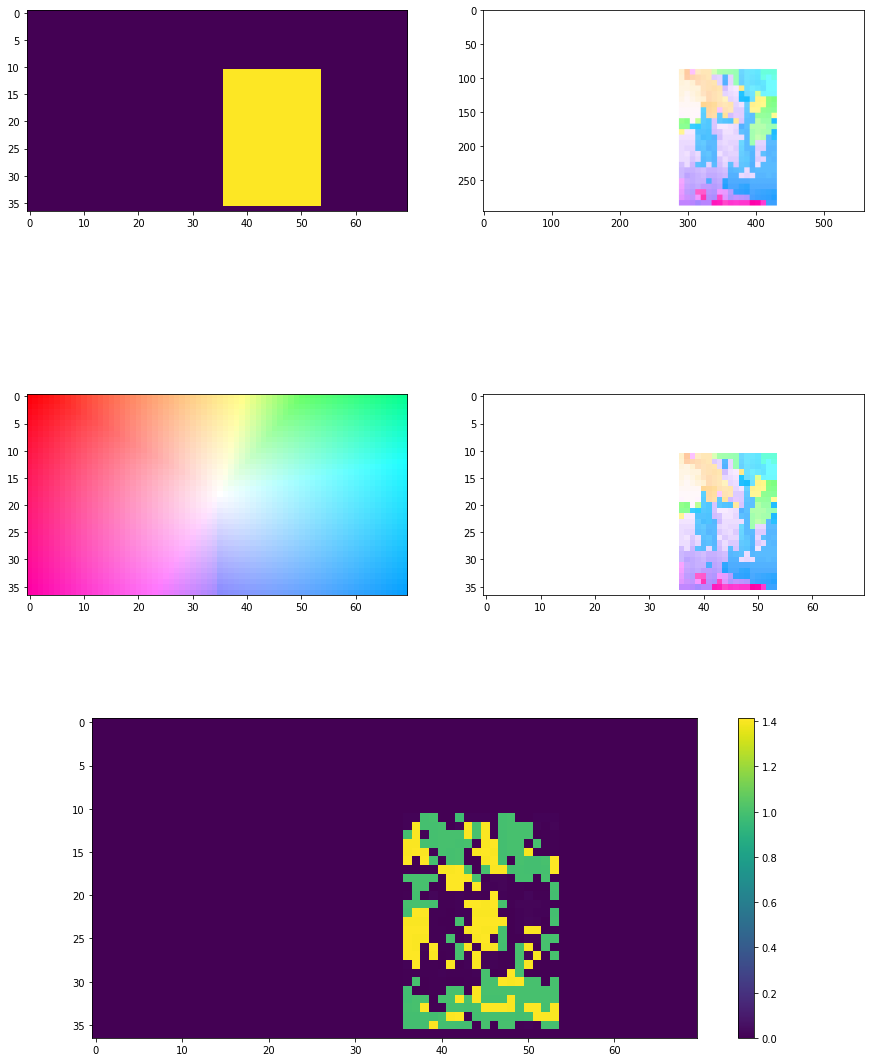

In [10]:
# error
err = (input_flow_downsampled[:, :, ::-1] - flow[0]).astype(np.float) / 255
err = (err ** 2).sum(-1) ** 0.5

fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(321)
plt.imshow(mask_downsampled.astype(np.float) / 255)
ax.set_aspect('equal')
ax = fig.add_subplot(322)
plt.imshow(input_flow[0][:, :, ::-1].astype(np.float) / 255)
ax.set_aspect('equal')
ax = fig.add_subplot(323)
plt.imshow(colormap[0].astype(np.float) / 255)
ax.set_aspect('equal')
ax = fig.add_subplot(324)
plt.imshow(flow[0].astype(np.float) / 255)
ax.set_aspect('equal')
ax = fig.add_subplot(313)
plt.imshow(err)
plt.colorbar()
ax.set_aspect('equal')

In [11]:
sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True
with tf.Session(config=sess_config) as sess:
    input_image = tf.constant(input_image, dtype=tf.float32)
    input_att = tf.constant(input_att, dtype=tf.float32)
    output, flow, attention = model.build_server_graph(input_image, input_att)
    def toimg(t):
        t = (t + 1.) * 127.5
        t = tf.reverse(t, [-1])
        t = tf.saturate_cast(t, tf.uint8)
        return t
    output = toimg(output)
    flow = toimg(flow)
    # load pretrained model
    vars_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    assign_ops = []
    for var in vars_list:
        vname = var.name
        from_name = vname
        var_value = tf.contrib.framework.load_variable(args.checkpoint_dir, from_name)
        assign_ops.append(tf.assign(var, var_value))
    sess.run(assign_ops)
    print('Model loaded.')
    result, flow, attention = sess.run(output), sess.run(flow), sess.run(attention)
    
    result = np.array(result)
    result, coarse, fine = np.split(result, 3, axis=2)
    cv2.imwrite(args.output_modulated, result[0][:, :, ::-1])
    print('Shape of model output: {}'.format(result.shape))
    
    flow = np.array(flow)
    flow = cv2.resize(flow[0][:, :, ::-1], dsize=(w, h), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(args.output_flow_modulated, flow)
    print('Shape of model attention (colored): {}'.format(flow.shape))
    
    attention = np.array(attention)
    print('Shape of model attention (full): {}'.format(attention.shape))
    
print('Done')

Called: build_server_graph()
Shape of masked images: (1, 296, 560, 3)
Shape of masks: (1, 296, 560, 1)
Shape of attention values: (1, 37, 70, 2590)
Called: build_inpaint_net()
Shape of first-stage input: (1, 296, 560, 5)
Shape of first-stage output: (1, 296, 560, 3)
Shape of second-stage input: (1, 296, 560, 3)
Shape of second-stage conv branch output: (1, 74, 140, 128)
Shape of contextual attention input: (TensorShape([Dimension(1), Dimension(74), Dimension(140), Dimension(128)]), TensorShape([Dimension(1), Dimension(74), Dimension(140), Dimension(1)]))
Called: contextual_attention()
Shape of foreground features: (1, 74, 140, 128)
Shape of background features: (1, 74, 140, 128)
Shape of masks: (1, 74, 140, 1)
Shape of given attention values: (1, 37, 70, 2590)
Shape of background patches (raw_w): (1, 4, 4, 128, 2590)
Shape of resized foreground features: (1, 37, 70, 128)
Shape of resized background features: (1, 37, 70, 128)
Shape of resized masks: (1, 37, 70, 1)
Shape of downscaled ba